In [2]:
# Laplace problem on a unit square
#
# In this script we solve Laplace's equation `Δu = 0` on a unit square domain
# `Ω` with boundary `Γ`, subject to boundary conditions:
#
#         u = 0                 Γ_left
#     ∂_n u = 0                 Γ_bottom
#     ∂_n u = cos(1) cosh(y)    Γ_right
#         u = cosh(1) sin(x)    Γ_top
#
# This problem is constructed to contain all combinations of homogenous and
# heterogeneous, Dirichlet and Neumann type boundary conditions, as well as to
# have a known exact solution in `uexact = sin(x) cosh(y)`.

from nutils import mesh, function, solver, export, cli, testing
from nutils.expression_v2 import Namespace
import treelog


def main(nelems: int, etype: str, btype: str, degree: int):
    '''
    Laplace problem on a unit square.
    .. arguments::
       nelems [10]
         Number of elements along edge.
       etype [square]
         Type of elements (square/triangle/mixed).
       btype [std]
         Type of basis function (std/spline), availability depending on the
         selected element type.
       degree [1]
         Polynomial degree.
    '''

    # A unit square domain is created by calling the
    # :func:`nutils.mesh.unitsquare` mesh generator, with the number of elements
    # along an edge as the first argument, and the type of elements ("square",
    # "triangle", or "mixed") as the second. The result is a topology object
    # ``domain`` and a vectored valued geometry function ``geom``.

    domain, geom = mesh.unitsquare(nelems, etype)

    # To be able to write index based tensor contractions, we need to bundle all
    # relevant functions together in a namespace. Here we add the geometry ``x``,
    # a scalar ``basis``, and the solution ``u``. The latter is formed by
    # contracting the basis with a to-be-determined solution vector ``?lhs``.

    ns = Namespace()
    ns.x = geom
    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))
    ns.basis = domain.basis(btype, degree=degree)
    ns.u = function.dotarg('lhs', ns.basis)

    # We are now ready to implement the Laplace equation. In weak form, the
    # solution is a scalar field :math:`u` for which:
    #
    # .. math:: ∀ v: ∫_Ω \frac{dv}{dx_i} \frac{du}{dx_i} - ∫_{Γ_n} v f = 0.
    #
    # By linearity the test function :math:`v` can be replaced by the basis that
    # spans its space. The result is an integral ``res`` that evaluates to a
    # vector matching the size of the function space.

    res = domain.integral('∇_i(basis_n) ∇_i(u) dV' @ ns, degree=degree*2)
    res -= domain.boundary['right'].integral('basis_n cos(1) cosh(x_1) dS' @ ns, degree=degree*2)

    # The Dirichlet constraints are set by finding the coefficients that minimize
    # the error:
    #
    # .. math:: \min_u ∫_{\Gamma_d} (u - u_d)^2
    #
    # The resulting ``cons`` array holds numerical values for all the entries of
    # ``?lhs`` that contribute (up to ``droptol``) to the minimization problem.
    # All remaining entries are set to ``NaN``, signifying that these degrees of
    # freedom are unconstrained.

    sqr = domain.boundary['left'].integral('u^2 dS' @ ns, degree=degree*2)
    sqr += domain.boundary['top'].integral('(u - cosh(1) sin(x_0))^2 dS' @ ns, degree=degree*2)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # The unconstrained entries of ``?lhs`` are to be determined such that the
    # residual vector evaluates to zero in the corresponding entries. This step
    # involves a linearization of ``res``, resulting in a jacobian matrix and
    # right hand side vector that are subsequently assembled and solved. The
    # resulting ``lhs`` array matches ``cons`` in the constrained entries.

    lhs = solver.solve_linear('lhs', res, constrain=cons)

    # Once all entries of ``?lhs`` are establised, the corresponding solution can
    # be vizualised by sampling values of ``ns.u`` along with physical
    # coordinates ``ns.x``, with the solution vector provided via the
    # ``arguments`` dictionary. The sample members ``tri`` and ``hull`` provide
    # additional inter-point information required for drawing the mesh and
    # element outlines.

    bezier = domain.sample('bezier', 9)
    x, u = bezier.eval(['x_i', 'u'] @ ns, lhs=lhs)
    export.triplot('solution.png', x, u, tri=bezier.tri, hull=bezier.hull)

    # To confirm that our computation is correct, we use our knowledge of the
    # analytical solution to evaluate the L2-error of the discrete result.

    err = domain.integral('(u - sin(x_0) cosh(x_1))^2 dV' @ ns, degree=degree*2).eval(lhs=lhs)**.5
    treelog.user('L2 error: {:.2e}'.format(err))

    return cons, lhs, err

# If the script is executed (as opposed to imported), :func:`nutils.cli.run`
# calls the main function with arguments provided from the command line. For
# example, to keep with the default arguments simply run :sh:`python3
# laplace.py`. To select mixed elements and quadratic basis functions add
# :sh:`python3 laplace.py etype=mixed degree=2`.


if __name__ == '__main__':
    cli.run(main)

# Once a simulation is developed and tested, it is good practice to save a few
# strategic return values for regression testing. The :mod:`nutils.testing`
# module, which builds on the standard :mod:`unittest` framework, facilitates
# this by providing :func:`nutils.testing.TestCase.assertAlmostEqual64` for the
# embedding of desired results as compressed base64 data.


class test(testing.TestCase):

    def test_default(self):
        cons, lhs, err = main(nelems=4, etype='square', btype='std', degree=1)
        with self.subTest('constraints'):
            self.assertAlmostEqual64(cons, '''
                eNrbKPv1QZ3ip9sL1BgaILDYFMbaZwZj5ZnDWNfNAeWPESU=''')
        with self.subTest('left-hand side'):
            self.assertAlmostEqual64(lhs, '''
                eNoBMgDN/7Ed9eB+IfLboCaXNKc01DQaNXM14jXyNR82ZTa+NpI2oTbPNhU3bjf7Ngo3ODd+N9c3SNEU
                1g==''')
        with self.subTest('L2-error'):
            self.assertAlmostEqual(err, 1.63e-3, places=5)

    def test_spline(self):
        cons, lhs, err = main(nelems=4, etype='square', btype='spline', degree=2)
        with self.subTest('constraints'):
            self.assertAlmostEqual64(cons, '''
                eNqrkmN+sEfhzF0xleRbDA0wKGeCYFuaIdjK5gj2aiT2VXMAJB0VAQ==''')
        with self.subTest('left-hand side'):
            self.assertAlmostEqual64(lhs, '''
                eNqrkmN+sEfhzF0xleRbrsauxsnGc43fGMuZJJgmmNaZ7jBlN7M08wLCDLNFZh/NlM0vmV0y+2CmZV5p
                vtr8j9kfMynzEPPF5lfNAcuhGvs=''')
        with self.subTest('L2-error'):
            self.assertAlmostEqual(err, 8.04e-5, places=7)

    def test_mixed(self):
        cons, lhs, err = main(nelems=4, etype='mixed', btype='std', degree=2)
        with self.subTest('constraints'):
            self.assertAlmostEqual64(cons, '''
                eNorfLZF2ucJQwMC3pR7+QDG9lCquAtj71Rlu8XQIGfC0FBoiqweE1qaMTTsNsOvRtmcoSHbHL+a1UD5
                q+YAxhcu1g==''')
        with self.subTest('left-hand side'):
            self.assertAlmostEqual64(lhs, '''
                eNorfLZF2ueJq7GrcYjxDJPpJstNbsq9fOBr3Gh8xWS7iYdSxd19xseMP5hImu5UZbv1xljOxM600DTW
                NN/0k2mC6SPTx6Z1pnNMGc3kzdaaPjRNMbMyEzWzNOsy223mBYRRZpPNJpktMks1azM7Z7bRbIXZabNX
                ZiLmH82UzS3Ns80vmj004za/ZPYHCD+Y8ZlLmVuYq5kHm9eahwDxavPF5lfNAWFyPdk=''')
        with self.subTest('L2-error'):
            self.assertAlmostEqual(err, 1.25e-4, places=6)

# example:tags=Laplace

argument 'f' requires a value


SystemExit: 2

In [2]:
# Laplace problem on a unit square
#
# In this script we solve Laplace's equation `Δu = 0` on a unit square domain
# `Ω` with boundary `Γ`, subject to boundary conditions:
#
#         u = 0                 Γ_left
#     ∂_n u = 0                 Γ_bottom
#     ∂_n u = cos(1) cosh(y)    Γ_right
#         u = cosh(1) sin(x)    Γ_top
#
# This problem is constructed to contain all combinations of homogenous and
# heterogeneous, Dirichlet and Neumann type boundary conditions, as well as to
# have a known exact solution in `uexact = sin(x) cosh(y)`.

from nutils import mesh, function, solver, export, cli, testing
from nutils.expression_v2 import Namespace
import treelog
import matplotlib.pyplot as plt


def main(nelems, etype, btype, degree):
    '''
    Laplace problem on a unit square.
    .. arguments::
       nelems [10]
         Number of elements along edge.
       etype [square]
         Type of elements (square/triangle/mixed).
       btype [std]
         Type of basis function (std/spline), availability depending on the
         selected element type.
       degree [1]
         Polynomial degree.
    '''

    # A unit square domain is created by calling the
    # :func:`nutils.mesh.unitsquare` mesh generator, with the number of elements
    # along an edge as the first argument, and the type of elements ("square",
    # "triangle", or "mixed") as the second. The result is a topology object
    # ``domain`` and a vectored valued geometry function ``geom``.

    domain, geom = mesh.unitsquare(nelems, etype)
    
    # To be able to write index based tensor contractions, we need to bundle all
    # relevant functions together in a namespace. Here we add the geometry ``x``,
    # a scalar ``basis``, and the solution ``u``. The latter is formed by
    # contracting the basis with a to-be-determined solution vector ``?lhs``.

    ns = Namespace()
    ns.x = geom
    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))
    ns.basis = domain.basis(btype, degree=degree)
    ns.u = function.dotarg('lhs', ns.basis)

    # We are now ready to implement the Laplace equation. In weak form, the
    # solution is a scalar field :math:`u` for which:
    #
    # .. math:: ∀ v: ∫_Ω \frac{dv}{dx_i} \frac{du}{dx_i} - ∫_{Γ_n} v f = 0.
    #
    # By linearity the test function :math:`v` can be replaced by the basis that
    # spans its space. The result is an integral ``res`` that evaluates to a
    # vector matching the size of the function space.

    res = domain.integral('∇_i(basis_n) ∇_i(u) dV' @ ns, degree=degree*2)
    res -= domain.boundary['right'].integral('basis_n cos(1) cosh(x_1) dS' @ ns, degree=degree*2)

    # The Dirichlet constraints are set by finding the coefficients that minimize
    # the error:
    #
    # .. math:: \min_u ∫_{\Gamma_d} (u - u_d)^2
    #
    # The resulting ``cons`` array holds numerical values for all the entries of
    # ``?lhs`` that contribute (up to ``droptol``) to the minimization problem.
    # All remaining entries are set to ``NaN``, signifying that these degrees of
    # freedom are unconstrained.

    sqr = domain.boundary['left'].integral('u^2 dS' @ ns, degree=degree*2)
    sqr += domain.boundary['top'].integral('(u - cosh(1) sin(x_0))^2 dS' @ ns, degree=degree*2)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # The unconstrained entries of ``?lhs`` are to be determined such that the
    # residual vector evaluates to zero in the corresponding entries. This step
    # involves a linearization of ``res``, resulting in a jacobian matrix and
    # right hand side vector that are subsequently assembled and solved. The
    # resulting ``lhs`` array matches ``cons`` in the constrained entries.

    lhs = solver.solve_linear('lhs', res, constrain=cons)

    # Once all entries of ``?lhs`` are establised, the corresponding solution can
    # be vizualised by sampling values of ``ns.u`` along with physical
    # coordinates ``ns.x``, with the solution vector provided via the
    # ``arguments`` dictionary. The sample members ``tri`` and ``hull`` provide
    # additional inter-point information required for drawing the mesh and
    # element outlines.

    bezier = domain.sample('bezier', 9)
    x, u = bezier.eval(['x_i', 'u'] @ ns, lhs=lhs)
    
    #plot
    # plt.tripcolor(x[:,0], x[:,1], u)
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    
    # To confirm that our computation is correct, we use our knowledge of the
    # analytical solution to evaluate the L2-error of the discrete result.

    err = domain.integral('(u - sin(x_0) cosh(x_1))^2 dV' @ ns, degree=degree*2).eval(lhs=lhs)**.5
    treelog.user('L2 error: {:.2e}'.format(err))

    return cons, lhs, err

In [3]:
# cons, lhs, err = main(10, 'square', 'std', degree)

std
square
1
optimize > solve > solving 21 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 0e+00
optimize > constrained 21/121 dofs
optimize > optimum value 4.32e-10


/home/prins/.local/lib/python3.10/site-packages/nutils/matrix/_base.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  treelog.debug('residual decreased by {:.1f} orders using {} krylov vectors'.format(numpy.log10(resnorm/newresnorm), len(krylov)))


solve > solving 100 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-15
L2 error: 2.56e-04
std
square
2
optimize > solve > solving 41 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 3e-17
optimize > constrained 41/441 dofs
optimize > optimum value 3.68e-11
solve > solving 400 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15
L2 error: 5.11e-06
std
square
3
optimize > solve > solving 61 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 5e-17
optimize > constrained 61/961 dofs
optimize > optimum value 0.00e+00
solve > solving 900 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15
L2 error: 2.31e-08
std
square
4
optimize > solve > solving 81 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 3e-17
o

/home/prins/.local/lib/python3.10/site-packages/nutils/matrix/_base.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  treelog.debug('residual decreased by {:.1f} orders using {} krylov vectors'.format(numpy.log10(resnorm/newresnorm), len(krylov)))


solve > solving 100 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15
L2 error: 1.06e-03
std
triangle
2
optimize > solve > solving 41 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 4e-17
optimize > constrained 41/441 dofs
optimize > optimum value 3.68e-11
solve > solving 400 dof system to machine precision using arnoldi solver
solve > solver returned with residual 3e-15
L2 error: 9.06e-06
std
triangle
3
optimize > solve > solving 61 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 2e-17
optimize > constrained 61/961 dofs
optimize > optimum value 0.00e+00
solve > solving 900 dof system to machine precision using arnoldi solver
solve > solver returned with residual 3e-15
L2 error: 5.57e-08
std
triangle
4
optimize > solve > solving 81 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 6

/home/prins/.local/lib/python3.10/site-packages/nutils/matrix/_base.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  treelog.debug('residual decreased by {:.1f} orders using {} krylov vectors'.format(numpy.log10(resnorm/newresnorm), len(krylov)))


solve > solving 100 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15
L2 error: 7.05e-04
std
mixed
2
optimize > solve > solving 41 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 3e-17
optimize > constrained 41/441 dofs
optimize > optimum value 3.68e-11
solve > solving 400 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15
L2 error: 8.17e-06
std
mixed
3
optimize > solve > solving 61 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 5e-17
optimize > constrained 61/961 dofs
optimize > optimum value 0.00e+00
solve > solving 900 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15
L2 error: 4.73e-08
std
mixed
4
optimize > solve > solving 81 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 3e-17
opti

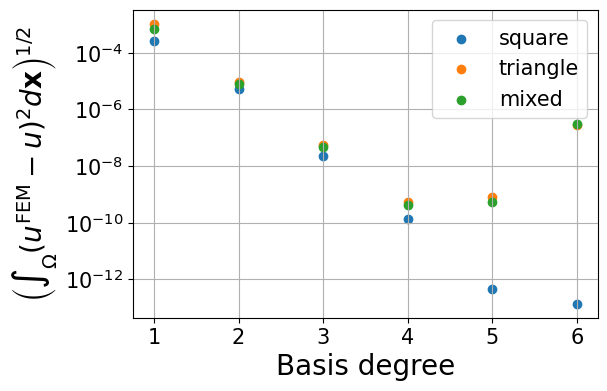

In [6]:
btypes = ['std']
etypes = ['square', 'triangle', 'mixed']
degrees = [1,2,3,4,5,6]

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
ax.grid()

for btype in btypes:
    for etype in etypes:
        errs = []
        for degree in degrees:
            print(btype)
            print(etype)
            print(degree)
            cons, lhs, err = main(nelems=10, etype=etype, btype=btype, degree=degree)
            errs.append(err)
        plt.scatter(degrees, errs, label=etype)
        ax.set_yscale('log')
        ax.set_xlabel('Basis degree',fontsize=20)
        ax.set_ylabel(r'$\left(\int_{\Omega}\left(u^{\mathrm{FEM}} - u\right)^2d\mathbf{x}\right)^{1/2}$',fontsize=20)
        ax.set_xticks(degrees)
        ax.legend(fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        # ax.ticklabel_format(style='sci', scilimits=[-3,3])
        plt.savefig("L2_vs_basisorder.pdf", bbox_inches='tight')